In [69]:
! pip install keras
! pip install tensorflow

Fonte: [Brain Tumor Dataset](https://www.kaggle.com/datasets/jakeshbohaju/brain-tumor)

**N.B.**: la sezione relativa al ricerca degli iperparametri è stata commentata 
per evitare l'esecuzione del codice. Questa scelta è stata fatta per evitare
l'eccessivo tempo di esecuzione del notebook.

I risultati ottenuti sono stati salvati in un file NN_Hyperparameters.json.

# Appunti per la creazione della rete

- **Dense**: implements the operation:
```
output = activation(dot(input, kernel) + bias)
```
where activation is the element-wise activation function passed as the activation argument
- **Bainary Cross Entropy**: computes the cross-entropy loss between true labels and predicted labels.
Use this cross-entropy loss for binary (0 or 1) classification applications. The loss function requires the following inputs:
 - y_true (true label): This is either 0 or 1.
 - y_pred (predicted value): This is the model's prediction, i.e, a single floating-point value which either represents a logit, (i.e, value in [-inf, inf] when from_logits=True) or a probability (i.e, value in [0., 1.] when from_logits=False).
- **SGD**: Gradient descent (with momentum) optimizer.
- **ADAM**:

# Rete Neurale

In [70]:
import pandas as pd
import warnings
# Esecuzione in remoto
# from google.colab import drive

# drive.mount('/content/drive/')

warnings.filterwarnings('ignore')

In [71]:
# Esecuzione in locale
path_to_dataset = './Dataset/Brain Tumor.csv'
path_to_hyperparameter = "./" + "NN_Hyperparameters.json"
path_for_json = "./NN_Hyperparameters"

# Esecuzione in remoto
# path_to_dataset = '/content/drive/MyDrive/Magistrale/Machine Learning/Progetto/Brain Tumor.csv'
# path_to_hyperparameter = "/content/drive/MyDrive/Magistrale/Machine Learning/" + "NN_Hyperparameters.json"
# path_for_json = "/content/drive/MyDrive/Magistrale/Machine Learning/NN_Hyperparameters"    

In [72]:
dataset = pd.read_csv(path_to_dataset, index_col=0)

## Preprocessing del dataset

In [73]:
dataset.dtypes

Class                   int64
Mean                  float64
Variance              float64
Standard Deviation    float64
Entropy               float64
Skewness              float64
Kurtosis              float64
Contrast              float64
Energy                float64
ASM                   float64
Homogeneity           float64
Dissimilarity         float64
Correlation           float64
Coarseness            float64
dtype: object

In [74]:
# Trasformo la variabile target in una variabile categorica
dataset["Class"] = dataset["Class"].astype("category")

# Dalle analisi precedenti abbiamo deciso di utilizzare questi attributi per addestrare il nostro modello
dataset = dataset[['Mean', 'Entropy', 'Skewness', 'Contrast', 'Correlation', 'Class']]

dataset.head()

,Mean,Entropy,Skewness,Contrast,Correlation,Class
Image,,,,,,
Image1,6.535339,0.109059,4.276477,98.613971,0.981939,0
Image2,8.749969,0.266538,3.718116,63.858816,0.988834,0
Image3,7.341095,0.001467,5.061750,81.867206,0.978014,1
Image4,5.958145,0.001477,5.677977,151.229741,0.964189,1
Image5,7.315231,0.146761,4.283221,174.988756,0.972789,0


In [75]:
y = dataset['Class']
X = dataset.drop(['Class'], axis=1)

columns_name = X.columns

Per le reti neurali risulta utile standardizzare i dati

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X[columns_name] = scaler.fit_transform(X)
X.head()

,Mean,Entropy,Skewness,Contrast,Correlation
Image,,,,,
Image1,-0.515700,0.504650,0.067855,-0.268050,1.000713
Image2,-0.129018,2.746050,-0.150204,-0.585492,1.264377
Image3,-0.375013,-1.026708,0.374531,-0.421010,0.850636
Image4,-0.616481,-1.026561,0.615188,0.212525,0.322041
Image5,-0.379529,1.041256,0.070489,0.429532,0.650854


Suddividiamo ora i dati in Train e Test, abbiamo scelto di utilizzare l'80% dei
dati per il training e il restante 20% per il test.

In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Per evitare di introdurre errori nell'addestramento della rete abbiamo voluto
verificare che il dataset dopo lo split fosse ancora bilanciato

In [78]:
print("Dataset:\n\t-Negative", round((y.value_counts()[0]/y.shape[0]) * 100, 2),
      "%\n\t-Positive", round((y.value_counts()[1]/y.shape[0]) * 100, 2), "%")
print("Train data:\n\t- Negative", round((y_train.value_counts()[0] / y_train.shape[0]) * 100, 2),
      "%\n\t- Positive", round((y_train.value_counts()[1] / y_train.shape[0]) * 100, 2), "%")

Dataset:
	-Negative 55.26 %
	-Positive 44.74 %
Train data:
	- Negative 55.27 %
	- Positive 44.73 %


## Ricerca degli iperparametri

In [79]:
from keras.models import Sequential
from keras.layers import Dense
from itertools import product

In [80]:
def create_model(units=[6, 6], activation='relu', opt='adam', metric='accuracy', input_layer_size=5):
  # Creazione del modello
  model = Sequential()

  # Aggiunta layer di input e hidden layers
  model.add(Dense(units=units[0], input_shape=(input_layer_size,), activation=activation))

  if len(units) >= 2 and units[1] != 0:
    model.add(Dense(units=units[1], activation=activation))

  # Aggiunta del layer di output
  model.add(Dense(1, activation='sigmoid'))

  # Compilazione del modello
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[metric])

  return model

Parametri tra cui cercare la combinazione migliore

In [81]:
# Iperparametri
units = [0, 5, 10, 50]
activation = ['sigmoid', 'relu', 'leaky_relu']
optimizer = ['sgd', 'adam']
batch_size = [50, 100, 300]
epochs = [100, 300]

# Creazione di tutte le possibili combinazioni
param_combinations = list(product(units, units, activation, optimizer, batch_size, epochs))

# Rimuovo le combinazioni con 0 neuroni nel primo layer
list_to_remove = []

for i, params in enumerate(param_combinations):
  if params[0] == 0:
    list_to_remove.append(params)

for to_remove in list_to_remove:
  param_combinations.remove(to_remove)

print("Total combinations:", len(param_combinations))

Total combinations: 432


In [82]:
# Preparazione del dataset per la grid search
X_cross_val = pd.DataFrame(data = X_train, columns = columns_name)
Y_cross_val = pd.DataFrame(data = y_train, columns = ['Class'])

Y_cross_val = (Y_cross_val.reset_index()).drop(['Image'], axis=1)
X_cross_val = (X_cross_val.reset_index()).drop(['Image'], axis=1)

In [83]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import scipy.stats as st
import numpy as np
import time
import json

In [84]:
def compute_statistics(performance, i):
    accuracy_score = performance[i]['results']
    time_score = performance[i]['time']
    performance[i]['interval90'] = st.t.interval(confidence=0.90, df=len(accuracy_score)-1, loc=np.mean(accuracy_score), scale=st.sem(accuracy_score))
    performance[i]['times'] = st.t.interval(confidence=0.90, df=len(time_score)-1, loc=np.mean(time_score), scale=st.sem(time_score))
    performance[i]['meanTime'] = sum(performance[i]['time']) / len(performance[i]['time'])
    performance[i]['meanAccuracy'] = sum(accuracy_score) / len(accuracy_score)

    return performance

def grid_search_NN(param_combinations, n_splits = 5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Dizionario per salvare i risultati della grid search
    performance = dict()

    # Ciclo per testare tutte le combinazioni
    for i, (u1, u2, act, opt, batch, ep) in enumerate(tqdm(param_combinations)):
        # Inizializzazione del dizionario per la combinazione corrente
        performance[i] = dict()
        performance[i]['param'] = ([u1, u2], act, opt, batch, ep)
        performance[i]['results'] = []
        performance[i]['time'] = []

        # Creazione del modello
        model = create_model(units=[u1, u2], activation=act, opt=opt)

        # Addestramento del modello e valutazione
        for train_idx, test_idx in skf.split(X_cross_val, Y_cross_val):
            X_val_train, X_val_test = X_cross_val.iloc[train_idx], X_cross_val.iloc[test_idx]
            y_val_train, y_val_test = Y_cross_val.iloc[train_idx], Y_cross_val.iloc[test_idx]

            start = time.time()

            model.fit(X_val_train, y_val_train, epochs=ep, batch_size=batch, verbose=0)

            end = time.time()

            # Evaluate the model on the test set
            score = model.evaluate(X_val_test, y_val_test, verbose=0)
            performance[i]['results'].append(score[1])
            performance[i]['time'].append(end - start)

        # Calcolo delle statistiche
        performance = compute_statistics(performance, i)

    # Salvataggio dei risultati su file
    with open(str(path_for_json + ".json"), "w") as outfile:
        json.dump(performance, outfile)

    return performance

In [85]:
def find_best_hyperparameters(performance):
    performance_interval90 = dict()
    performance_times = dict()
    performance_time = dict()
    performance_acc = dict()

    for key in list(performance.keys()):
        interval90 = performance[key]['interval90']
        interval95 = performance[key]['times']

        performance_interval90[key] = interval90[1] - interval90[0]
        performance_times[key] = interval95[1] - interval95[0]
        performance_time[key] = performance[key]['meanTime']
        performance_acc[key] = performance[key]['meanAccuracy']

    performance_interval90 = sorted(performance_interval90.items(), key=lambda x:x[1])
    performance_times = sorted(performance_times.items(), key=lambda x:x[1])
    performance_time = sorted(performance_time.items(), key=lambda x:x[1])
    performance_acc = sorted(performance_acc.items(), key=lambda x:x[1], reverse=True)

    sorted_dict = dict()

    for i, (index, _) in enumerate(performance_interval90):
        sorted_dict[index] = dict()
        sorted_dict[index]['90'] = i + 1

    for i, (index, _) in enumerate(performance_times):
        sorted_dict[index]['times_90'] = i + 1

    for i, (index, _) in enumerate(performance_time):
        sorted_dict[index]['time'] = i + 1

    for i, (index, _) in enumerate(performance_acc):
        sorted_dict[index]['acc'] = i + 1

    # Creazione del dataframe per la valutazione dei risultati
    dataframe_model = pd.DataFrame(sorted_dict)
    dataframe_model = dataframe_model.T

    # Assegno dei pesi per ogni parametro
    weights = pd.Series([1, 1, 2, 2], index=dataframe_model.columns)

    # Calcolo del punteggio totale
    dataframe_model['Total'] = (dataframe_model * weights).sum(axis=1)
    dataframe_model = dataframe_model.sort_values(by=['Total'])
    
    # Restituisco i parametri del modello migliore
    best_model_index = dataframe_model.index[0]
    return performance[best_model_index]['param']

#### Selezione degli iperparametri

In [86]:
# performance = grid_search_NN(param_combinations)
# best_model = find_best_hyperparameters(performance)

## Addestramento del modello

In [87]:
best_model = ([[50, 0], 'leaky_relu', 'adam', 100, 100])

In [88]:
# Creazione del modello con i migliori iperparametri
model = create_model(units=best_model[0], activation=best_model[1], opt=best_model[2], input_layer_size=X_train.shape[1])

# Addestramento del modello
model.fit(X_train, y_train, epochs=best_model[4], batch_size=best_model[3], verbose=0)

## Valutazione del modello

Valutazione del modello attraverso le metriche fornite da Keras

In [89]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03812390938401222
Test accuracy: 0.9893758296966553


Valutazione del modello utilizzando altre metriche

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Definizione di una funzione per associare un etichetta ai risultati della rete.

In [91]:
def my_predict(model, X_test, threshold=0.5):
    # Predizione del modello
    y_pred = model.predict(X_test)

    # Applicazione della soglia
    y_pred = np.where(y_pred > threshold, 1, 0).flatten()

    # Restituisco le predizioni
    return y_pred

In [92]:
# Valutazione del modello utilizzando i dati di test
y_pred = my_predict(model, X_test, 0.2)

# Calcolo delle prestazioni del modello
accuracy_train_test = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

24/24 [==============================] - 0s 2ms/step
Accuracy: 0.9814077025232404
Precision: 0.9708454810495627
Recall: 0.9881305637982196
F1-score: 0.9794117647058824


Calcolo della matrice di confusione

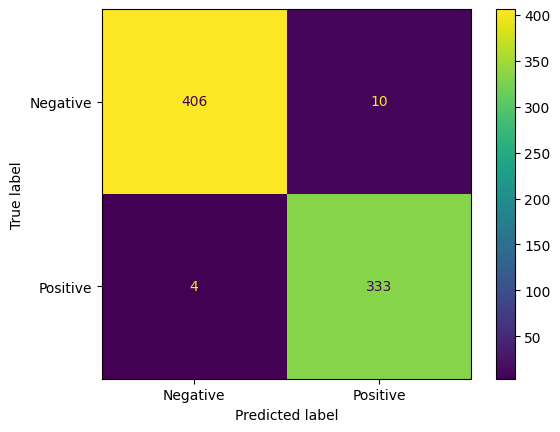

In [93]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

Report della classificazione

In [94]:
classification_report(y_pred, y_test)

'              precision    recall  f1-score   support\n\n           0       0.98      0.99      0.98       410\n           1       0.99      0.97      0.98       343\n\n    accuracy                           0.98       753\n   macro avg       0.98      0.98      0.98       753\nweighted avg       0.98      0.98      0.98       753\n'

Calcolo e disegno della curva ROC

24/24 [==============================] - 0s 864us/step


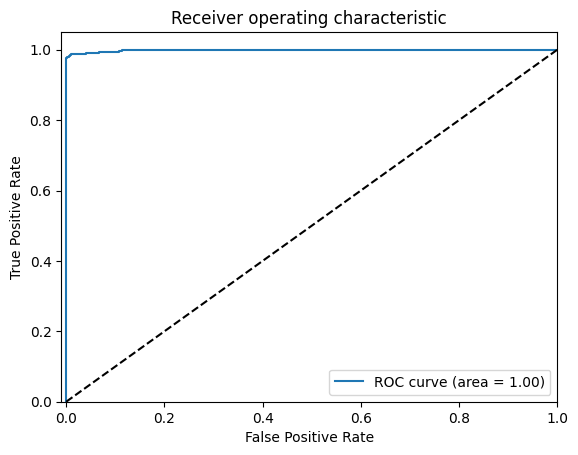

In [95]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcola le probabilità delle predizioni
y_pred_prob = model.predict(X_test)

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC della curva ROC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Valutazione del modello attraverso 10-fold validation

In [96]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)

# Inizializzazione delle liste per le prestazioni
accuracy_stratified = []
recall_stratified = []
precision_stratified = []
fscore_stratified = []

# Ciclo per la validazione incrociata
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
  # Split train and validation set
  X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
  y_train, y_valid = y[train_idx], y[valid_idx]

  # Creazione del modello
  model = create_model(units=best_model[0], activation=best_model[1], opt=best_model[2], input_layer_size=X_train.shape[1])

  # Addestramento del modello
  model.fit(X_train, y_train, epochs=best_model[4], batch_size=best_model[3], verbose=0)

  # Valutazione del modello
  y_pred_valid = my_predict(model, X_valid)

  accuracy_stratified.append(accuracy_score(y_valid, y_pred_valid))
  precision_stratified.append(precision_score(y_valid, y_pred_valid))
  recall_stratified.append(recall_score(y_valid, y_pred_valid))
  fscore_stratified.append(f1_score(y_valid, y_pred_valid))

12/12 [==============================] - 0s 2ms/step


Calcolo dell'intervallo di confidenza

In [97]:
confidence = 0.90
# Calcolo degli intervalli di confidenza
acc_interval = st.t.interval(confidence=confidence, df=len(accuracy_stratified)-1, loc=np.mean(accuracy_stratified), scale=st.sem(accuracy_stratified))
precision_interval = st.t.interval(confidence=confidence, df=len(precision_stratified)-1, loc=np.mean(precision_stratified), scale=st.sem(precision_stratified))
recall_interval = st.t.interval(confidence=confidence, df=len(recall_stratified)-1, loc=np.mean(recall_stratified), scale=st.sem(recall_stratified))
fscore_interval = st.t.interval(confidence=confidence, df=len(fscore_stratified)-1, loc=np.mean(fscore_stratified), scale=st.sem(fscore_stratified))

print("Accuracy:", np.mean(accuracy_stratified), acc_interval)
print("Precision:", np.mean(precision_stratified), precision_interval)
print("Recall:", np.mean(recall_stratified), recall_interval)
print("F1-score:", np.mean(fscore_stratified), fscore_interval)

Accuracy: 0.9835183983294769 (0.9800466679106246, 0.9869901287483291)
Precision: 0.9885801095193532 (0.9848011231100795, 0.9923590959286268)
Recall: 0.9744399830938294 (0.9683365219804013, 0.9805434442072575)
F1-score: 0.98143064447897 (0.9774723860980314, 0.9853889028599085)


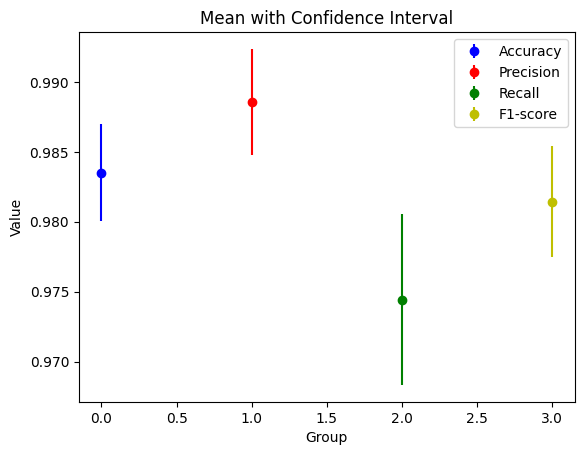

In [98]:
# Plot the mean and confidence interval
plt.errorbar(0, np.mean(acc_interval), yerr=(acc_interval[1] - acc_interval[0])/2, fmt='o', label='Accuracy', color='b')
plt.errorbar(1, np.mean(precision_interval), yerr=(precision_interval[1] - precision_interval[0])/2, fmt='o', label='Precision', color='r')
plt.errorbar(2, np.mean(recall_interval), yerr=(recall_interval[1] - recall_interval[0])/2, fmt='o', label='Recall', color='g')
plt.errorbar(3, np.mean(fscore_interval), yerr=(fscore_interval[1] - fscore_interval[0])/2, fmt='o', label='F1-score', color='y')

# Add labels and title
plt.xlabel('Group')
plt.ylabel('Value')
plt.title('Mean with Confidence Interval')

# Show the plot
plt.legend()
plt.show()